<a href="https://colab.research.google.com/github/mfrdixon/alpha-RNN/blob/master/KerasLayer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Jan 14 23:15:31 2020

@author: macbookpro
"""
 

# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import pandas as pd
from numpy import random
import os# Generate switching data set
import random


# Imports for alpha_rnns 
from IPython import display
import tensorflow.compat.v1 as tf   
tf.disable_v2_behavior()
# Imports for stats
from keras.layers import Dense, Input
from keras.models import Model
import numpy as np
from keras.layers import Layer
from keras import backend as K
from keras import optimizers
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU, SimpleRNN
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.regularizers import l1,l2
from keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from keras import layers
#from alphaRNN import *
from keras import *
from keras.legacy import interfaces
# To make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot figures
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)
    
def generate_vol_sample(length, sigma_0, n_steps, step_size, p, eps=0.01, shift=0):
    sigma = np.array([0]*length, dtype='float64')
    sigma[0]=sigma_0
    mu = np.array([0]*length, dtype='float64')
    phi = np.array([0]*length*p, dtype='float64').reshape(length,p)
    #phi2 = np.array([0]*length, dtype='float64')
    step_length=100 #np.int(np.floor(np.float(length)/(2.0*n_steps)))
    
    for i in range(2*n_steps):
      #mu[i*step_length:((i*step_length)+1)]=step_size #*(-1)**i
      mu[i*step_length:((i+1)*step_length)]= step_size*(-1)**i
      if i%2==0:  
        phi[i*step_length:((i+1)*step_length),:]= 0.02
        #phi2[i*step_length:((i+1)*step_length)]=1.0
      else:
        phi[i*step_length:((i+1)*step_length),:]=0.01
        #phi2[i*step_length:((i+1)*step_length)]=0.5
    for i in range(p, length):
        sigma[i]= mu[i-1] + np.random.normal(0,eps)
        for j in range(p):
          sigma[i]+=phi[i-1,j]*sigma[i-j]  
        
    return (sigma+shift)

p = 30 # the number of lags (in both the data and the models)
vols=generate_vol_sample(2000, 0.25, 15, 0.1, p, 1e-4, 0.13)[p:]

df = pd.DataFrame(vols, columns=['vol'])

use_features = ['vol'] 
target = 'vol'
n_steps = 10 # number of lags to include in the model

train_weight = 0.8
split = int(len(df)*train_weight)

df_train = df[use_features].iloc[:split]
print(df_train)
df_test = df[use_features].iloc[split:]

def get_lagged_features(value, n_steps):
    lag_list = []
    for lag in range(n_steps, 0, -1):
        lag_list.append(value.shift(lag))
    return pd.concat(lag_list, axis=1)

x_train_list = []
for use_feature in use_features:
    x_train_reg = get_lagged_features(df_train, n_steps).dropna()
    x_train_list.append(x_train_reg)
#x_train_reg = pd.concat(x_train_list, axis=1)

col_ords = []
for i in range(n_steps):
    for j in range(len(use_features)):
        col_ords.append(i + j * n_steps)

#x_train_reg = x_train_reg.iloc[:, col_ords]
#y_train_reg = df_train.loc[x_train_reg.index, [target]].values
#x_train_reg = np.reshape(x_train_reg.values, (x_train_reg.shape[0], np.int(x_train_reg.shape[1] / len(use_features)), len(use_features)))
#y_train_reg = np.reshape(y_train_reg, (y_train_reg.shape[0], 1, 1))

x_test_list = []
for use_feature in use_features:
    x_test_reg = get_lagged_features(df_test, n_steps).dropna()
    x_test_list.append(x_test_reg)
#x_test_reg = pd.concat(x_test_list, axis=1)

#x_test_reg = x_test_reg.iloc[:, col_ords]
#y_test_reg = df_test.loc[x_test_reg.index, [target]].values
#x_test_reg = np.reshape(x_test_reg.values, (x_test_reg.shape[0], np.int(x_test_reg.shape[1]/len(use_features)), len(use_features)))

#y_test_reg = np.reshape(y_test_reg, (y_test_reg.shape[0], 1, 1))

#train_batch_size = y_train_reg.shape[0]
#test_batch_size = y_test_reg.shape[0]    





           vol
0     0.231685
1     0.233905
2     0.236207
3     0.238376
4     0.240477
...        ...
1571  0.149595
1572  0.152918
1573  0.156165
1574  0.159597
1575  0.163079

[1576 rows x 1 columns]


In [0]:
class AlphaRNNCell(Layer):
    """Cell class for AlphaRNN.
    # Arguments
        units: Positive integer, dimensionality of the output space.
        activation: Activation function to use
            (see [activations](../activations.md)).
            Default: hyperbolic tangent (`tanh`).
            If you pass `None`, no activation is applied
            (ie. "linear" activation: `a(x) = x`).
        use_bias: Boolean, whether the layer uses a bias vector.
        kernel_initializer: Initializer for the `kernel` weights matrix,
            used for the linear transformation of the inputs
            (see [initializers](../initializers.md)).
        recurrent_initializer: Initializer for the `recurrent_kernel`
            weights matrix,
            used for the linear transformation of the recurrent state
            (see [initializers](../initializers.md)).
        bias_initializer: Initializer for the bias vector
            (see [initializers](../initializers.md)).
        kernel_regularizer: Regularizer function applied to
            the `kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        recurrent_regularizer: Regularizer function applied to
            the `recurrent_kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        bias_regularizer: Regularizer function applied to the bias vector
            (see [regularizer](../regularizers.md)).
        kernel_constraint: Constraint function applied to
            the `kernel` weights matrix
            (see [constraints](../constraints.md)).
        recurrent_constraint: Constraint function applied to
            the `recurrent_kernel` weights matrix
            (see [constraints](../constraints.md)).
        bias_constraint: Constraint function applied to the bias vector
            (see [constraints](../constraints.md)).
        dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the inputs.
        recurrent_dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the recurrent state.
    """

    def __init__(self, units,
                 activation='tanh',
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 recurrent_initializer='orthogonal',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 recurrent_regularizer=None,
                 bias_regularizer=None,
                 kernel_constraint=None,
                 recurrent_constraint=None,
                 bias_constraint=None,
                 dropout=0.,
                 recurrent_dropout=0.,
                 **kwargs):
        super(AlphaRNNCell, self).__init__(**kwargs)
        self.units = units
        self.activation = activations.get(activation)
        self.use_bias = use_bias

        self.kernel_initializer = initializers.get(kernel_initializer)
        self.recurrent_initializer = initializers.get(recurrent_initializer)
        self.bias_initializer = initializers.get(bias_initializer)

        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.recurrent_regularizer = regularizers.get(recurrent_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)

        self.kernel_constraint = constraints.get(kernel_constraint)
        self.recurrent_constraint = constraints.get(recurrent_constraint)
        self.bias_constraint = constraints.get(bias_constraint)

        self.dropout = min(1., max(0., dropout))
        self.recurrent_dropout = min(1., max(0., recurrent_dropout))
        self.state_size = self.units
        self.output_size = self.units
        self._dropout_mask = None
        self._recurrent_dropout_mask = None

    def build(self, input_shape):
        self.kernel = self.add_weight(shape=(input_shape[-1], self.units),
                                      name='kernel',
                                      initializer=self.kernel_initializer,
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        self.recurrent_kernel = self.add_weight(
            shape=(self.units, self.units),
            name='recurrent_kernel',
            initializer=self.recurrent_initializer,
            regularizer=self.recurrent_regularizer,
            constraint=self.recurrent_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.units,),
                                        name='bias',
                                        initializer=self.bias_initializer,
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        
        self.alpha = self.add_weight(shape=(1,),
                                        name='alpha',
                                        initializer=self.bias_initializer,
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        self.built = True

    def call(self, inputs, states, training=None):
        prev_output = states[0]
        if 0 < self.dropout < 1 and self._dropout_mask is None:
            self._dropout_mask = _generate_dropout_mask(
                K.ones_like(inputs),
                self.dropout,
                training=training)
        if (0 < self.recurrent_dropout < 1 and
                self._recurrent_dropout_mask is None):
            self._recurrent_dropout_mask = _generate_dropout_mask(
                K.ones_like(prev_output),
                self.recurrent_dropout,
                training=training)

        dp_mask = self._dropout_mask
        rec_dp_mask = self._recurrent_dropout_mask

        if dp_mask is not None:
            h = K.dot(inputs * dp_mask, self.kernel)
        else:
            h = K.dot(inputs, self.kernel)
        if self.bias is not None:
            h = K.bias_add(h, self.bias)

        if rec_dp_mask is not None:
            prev_output *= rec_dp_mask
        output = h + K.dot(prev_output, self.recurrent_kernel)
        if self.activation is not None:
            output = self.activation(output)
        output = K.tanh(self.alpha)* output + 1-K.tanh(self.alpha)* prev_output
        # Properly set learning phase on output tensor.
        if 0 < self.dropout + self.recurrent_dropout:
            if training is None:
                output._uses_learning_phase = True
        return output, [output]

    def get_config(self):
        config = {'units': self.units,
                  'activation': activations.serialize(self.activation),
                  'use_bias': self.use_bias,
                  'kernel_initializer':
                      initializers.serialize(self.kernel_initializer),
                  'recurrent_initializer':
                      initializers.serialize(self.recurrent_initializer),
                  'bias_initializer': initializers.serialize(self.bias_initializer),
                  'kernel_regularizer':
                      regularizers.serialize(self.kernel_regularizer),
                  'recurrent_regularizer':
                      regularizers.serialize(self.recurrent_regularizer),
                  'bias_regularizer': regularizers.serialize(self.bias_regularizer),
                  'kernel_constraint': constraints.serialize(self.kernel_constraint),
                  'recurrent_constraint':
                      constraints.serialize(self.recurrent_constraint),
                  'bias_constraint': constraints.serialize(self.bias_constraint),
                  'dropout': self.dropout,
                  'recurrent_dropout': self.recurrent_dropout}
        base_config = super(AlphaRNNCell, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


class AlphaRNN(keras.layers.RNN):
    """Fully-connected AlphaRNN where the output is to be fed back to input.
    # Arguments
        units: Positive integer, dimensionality of the output space.
        activation: Activation function to use
            (see [activations](../activations.md)).
            Default: hyperbolic tangent (`tanh`).
            If you pass `None`, no activation is applied
            (ie. "linear" activation: `a(x) = x`).
        use_bias: Boolean, whether the layer uses a bias vector.
        kernel_initializer: Initializer for the `kernel` weights matrix,
            used for the linear transformation of the inputs
            (see [initializers](../initializers.md)).
        recurrent_initializer: Initializer for the `recurrent_kernel`
            weights matrix,
            used for the linear transformation of the recurrent state
            (see [initializers](../initializers.md)).
        bias_initializer: Initializer for the bias vector
            (see [initializers](../initializers.md)).
        kernel_regularizer: Regularizer function applied to
            the `kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        recurrent_regularizer: Regularizer function applied to
            the `recurrent_kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        bias_regularizer: Regularizer function applied to the bias vector
            (see [regularizer](../regularizers.md)).
        activity_regularizer: Regularizer function applied to
            the output of the layer (its "activation").
            (see [regularizer](../regularizers.md)).
        kernel_constraint: Constraint function applied to
            the `kernel` weights matrix
            (see [constraints](../constraints.md)).
        recurrent_constraint: Constraint function applied to
            the `recurrent_kernel` weights matrix
            (see [constraints](../constraints.md)).
        bias_constraint: Constraint function applied to the bias vector
            (see [constraints](../constraints.md)).
        dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the inputs.
        recurrent_dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the recurrent state.
        return_sequences: Boolean. Whether to return the last output
            in the output sequence, or the full sequence.
        return_state: Boolean. Whether to return the last state
            in addition to the output.
        go_backwards: Boolean (default False).
            If True, process the input sequence backwards and return the
            reversed sequence.
        stateful: Boolean (default False). If True, the last state
            for each sample at index i in a batch will be used as initial
            state for the sample of index i in the following batch.
        unroll: Boolean (default False).
            If True, the network will be unrolled,
            else a symbolic loop will be used.
            Unrolling can speed-up a RNN,
            although it tends to be more memory-intensive.
            Unrolling is only suitable for short sequences.
    """

    @interfaces.legacy_recurrent_support
    def __init__(self, units,
                 activation='tanh',
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 recurrent_initializer='orthogonal',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 recurrent_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 recurrent_constraint=None,
                 bias_constraint=None,
                 dropout=0.,
                 recurrent_dropout=0.,
                 return_sequences=False,
                 return_state=False,
                 go_backwards=False,
                 stateful=False,
                 unroll=False,
                 **kwargs):
        if 'implementation' in kwargs:
            kwargs.pop('implementation')
            warnings.warn('The `implementation` argument '
                          'in `SimpleRNN` has been deprecated. '
                          'Please remove it from your layer call.')
        if K.backend() == 'theano' and (dropout or recurrent_dropout):
            warnings.warn(
                'RNN dropout is no longer supported with the Theano backend '
                'due to technical limitations. '
                'You can either set `dropout` and `recurrent_dropout` to 0, '
                'or use the TensorFlow backend.')
            dropout = 0.
            recurrent_dropout = 0.

        cell = AlphaRNNCell(units,
                             activation=activation,
                             use_bias=use_bias,
                             kernel_initializer=kernel_initializer,
                             recurrent_initializer=recurrent_initializer,
                             bias_initializer=bias_initializer,
                             kernel_regularizer=kernel_regularizer,
                             recurrent_regularizer=recurrent_regularizer,
                             bias_regularizer=bias_regularizer,
                             kernel_constraint=kernel_constraint,
                             recurrent_constraint=recurrent_constraint,
                             bias_constraint=bias_constraint,
                             dropout=dropout,
                             recurrent_dropout=recurrent_dropout)
        super(AlphaRNN, self).__init__(cell,
                                        return_sequences=return_sequences,
                                        return_state=return_state,
                                        go_backwards=go_backwards,
                                        stateful=stateful,
                                        unroll=unroll,
                                        **kwargs)
        self.activity_regularizer = regularizers.get(activity_regularizer)

    def call(self, inputs, mask=None, training=None, initial_state=None):
        self.cell._dropout_mask = None
        self.cell._recurrent_dropout_mask = None
        return super(AlphaRNN, self).call(inputs,
                                           mask=mask,
                                           training=training,
                                           initial_state=initial_state)

    @property
    def units(self):
        return self.cell.units

    @property
    def activation(self):
        return self.cell.activation

    @property
    def use_bias(self):
        return self.cell.use_bias

    @property
    def kernel_initializer(self):
        return self.cell.kernel_initializer

    @property
    def recurrent_initializer(self):
        return self.cell.recurrent_initializer

    @property
    def bias_initializer(self):
        return self.cell.bias_initializer

    @property
    def kernel_regularizer(self):
        return self.cell.kernel_regularizer

    @property
    def recurrent_regularizer(self):
        return self.cell.recurrent_regularizer

    @property
    def bias_regularizer(self):
        return self.cell.bias_regularizer

    @property
    def kernel_constraint(self):
        return self.cell.kernel_constraint

    @property
    def recurrent_constraint(self):
        return self.cell.recurrent_constraint

    @property
    def bias_constraint(self):
        return self.cell.bias_constraint

    @property
    def dropout(self):
        return self.cell.dropout

    @property
    def recurrent_dropout(self):
        return self.cell.recurrent_dropout

    def get_config(self):
        config = {'units': self.units,
                  'activation': activations.serialize(self.activation),
                  'use_bias': self.use_bias,
                  'kernel_initializer':
                      initializers.serialize(self.kernel_initializer),
                  'recurrent_initializer':
                      initializers.serialize(self.recurrent_initializer),
                  'bias_initializer': initializers.serialize(self.bias_initializer),
                  'kernel_regularizer':
                      regularizers.serialize(self.kernel_regularizer),
                  'recurrent_regularizer':
                      regularizers.serialize(self.recurrent_regularizer),
                  'bias_regularizer': regularizers.serialize(self.bias_regularizer),
                  'activity_regularizer':
                      regularizers.serialize(self.activity_regularizer),
                  'kernel_constraint': constraints.serialize(self.kernel_constraint),
                  'recurrent_constraint':
                      constraints.serialize(self.recurrent_constraint),
                  'bias_constraint': constraints.serialize(self.bias_constraint),
                  'dropout': self.dropout,
                  'recurrent_dropout': self.recurrent_dropout}
        base_config = super(AlphaRNN, self).get_config()
        del base_config['cell']
        return dict(list(base_config.items()) + list(config.items()))

    @classmethod
    def from_config(cls, config):
        if 'implementation' in config:
            config.pop('implementation')
        return cls(**config)

In [0]:
class AlphatRNNCell(Layer):
    """Cell class for the AlphatRNN layer.
    # Arguments
        units: Positive integer, dimensionality of the output space.
        activation: Activation function to use
            (see [activations](../activations.md)).
            Default: hyperbolic tangent (`tanh`).
            If you pass `None`, no activation is applied
            (ie. "linear" activation: `a(x) = x`).
        recurrent_activation: Activation function to use
            for the recurrent step
            (see [activations](../activations.md)).
            Default: hyperbolic tangent (`tanh`).
            If you pass `None`, no activation is applied
            (ie. "linear" activation: `a(x) = x`).
        use_bias: Boolean, whether the layer uses a bias vector.
        kernel_initializer: Initializer for the `kernel` weights matrix,
            used for the linear transformation of the inputs
            (see [initializers](../initializers.md)).
        recurrent_initializer: Initializer for the `recurrent_kernel`
            weights matrix,
            used for the linear transformation of the recurrent state
            (see [initializers](../initializers.md)).
        bias_initializer: Initializer for the bias vector
            (see [initializers](../initializers.md)).
        kernel_regularizer: Regularizer function applied to
            the `kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        recurrent_regularizer: Regularizer function applied to
            the `recurrent_kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        bias_regularizer: Regularizer function applied to the bias vector
            (see [regularizer](../regularizers.md)).
        kernel_constraint: Constraint function applied to
            the `kernel` weights matrix
            (see [constraints](../constraints.md)).
        recurrent_constraint: Constraint function applied to
            the `recurrent_kernel` weights matrix
            (see [constraints](../constraints.md)).
        bias_constraint: Constraint function applied to the bias vector
            (see [constraints](../constraints.md)).
        dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the inputs.
        recurrent_dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the recurrent state.
        implementation: Implementation mode, either 1 or 2.
            Mode 1 will structure its operations as a larger number of
            smaller dot products and additions, whereas mode 2 will
            batch them into fewer, larger operations. These modes will
            have different performance profiles on different hardware and
            for different applications.
    """

    def __init__(self, units,
                 activation='tanh',
                 recurrent_activation='tanh',
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 recurrent_initializer='orthogonal',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 recurrent_regularizer=None,
                 bias_regularizer=None,
                 kernel_constraint=None,
                 recurrent_constraint=None,
                 bias_constraint=None,
                 dropout=0.,
                 recurrent_dropout=0.,
                 implementation=2,
                 **kwargs):
        super(AlphatRNNCell, self).__init__(**kwargs)
        self.units = units
        self.activation = activations.get(activation)
        self.recurrent_activation = activations.get(recurrent_activation)
        self.use_bias = use_bias

        self.kernel_initializer = initializers.get(kernel_initializer)
        self.recurrent_initializer = initializers.get(recurrent_initializer)
        self.bias_initializer = initializers.get(bias_initializer)

        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.recurrent_regularizer = regularizers.get(recurrent_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)

        self.kernel_constraint = constraints.get(kernel_constraint)
        self.recurrent_constraint = constraints.get(recurrent_constraint)
        self.bias_constraint = constraints.get(bias_constraint)

        self.dropout = min(1., max(0., dropout))
        self.recurrent_dropout = min(1., max(0., recurrent_dropout))
        self.implementation = implementation
        self.state_size = self.units
        self.output_size = self.units
        self._dropout_mask = None
        self._recurrent_dropout_mask = None

    def build(self, input_shape):
        input_dim = input_shape[-1]

        if isinstance(self.recurrent_initializer, initializers.Identity):
            def recurrent_identity(shape, gain=1., dtype=None):
                del dtype
                return gain * np.concatenate(
                    [np.identity(shape[0])] * (shape[1] // shape[0]), axis=1)

            self.recurrent_initializer = recurrent_identity

        self.kernel = self.add_weight(shape=(input_dim, self.units * 2),
                                      name='kernel',
                                      initializer=self.kernel_initializer,
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        self.recurrent_kernel = self.add_weight(
            shape=(self.units, self.units * 2),
            name='recurrent_kernel',
            initializer=self.recurrent_initializer,
            regularizer=self.recurrent_regularizer,
            constraint=self.recurrent_constraint)

        if self.use_bias:
            bias_shape = (2, 2 * self.units)
            self.bias = self.add_weight(shape=bias_shape,
                                        name='bias',
                                        initializer=self.bias_initializer,
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
            
            self.input_bias = K.flatten(self.bias[0])
            self.recurrent_bias = K.flatten(self.bias[1])
        else:
            self.bias = None

        # alpha
        self.kernel_alpha = self.kernel[:, :self.units]
        self.recurrent_kernel_alpha = self.recurrent_kernel[:, :self.units]
        # recurrnce
        self.kernel_h = self.kernel[:, self.units:]
        self.recurrent_kernel_h = self.recurrent_kernel[:, self.units:]

        if self.use_bias:
            # bias for inputs
            self.input_bias_alpha = self.input_bias[:self.units]
            self.input_bias_h = self.input_bias[self.units:]
            # bias for hidden state - just for compatibility with CuDNN
            
            self.recurrent_bias_alpha = self.recurrent_bias[:self.units]    
            self.recurrent_bias_h = self.recurrent_bias[self.units:]
        else:
            self.input_bias_alpha = None
            self.input_bias_h = None
            
            self.recurrent_bias_alpha = None
            self.recurrent_bias_h = None
        self.built = True

    def call(self, inputs, states, training=None):
        h_tm1 = states[0]  # previous memory

        if 0 < self.dropout < 1 and self._dropout_mask is None:
            self._dropout_mask = _generate_dropout_mask(
                K.ones_like(inputs),
                self.dropout,
                training=training,
                count=2)
        if (0 < self.recurrent_dropout < 1 and
                self._recurrent_dropout_mask is None):
            self._recurrent_dropout_mask = _generate_dropout_mask(
                K.ones_like(h_tm1),
                self.recurrent_dropout,
                training=training,
                count=2)

        # dropout matrices for input units
        dp_mask = self._dropout_mask
        # dropout matrices for recurrent units
        rec_dp_mask = self._recurrent_dropout_mask

        if self.implementation == 1:
            if 0. < self.dropout < 1.:
                inputs_alpha = inputs * dp_mask[0]
                inputs_h = inputs * dp_mask[1]
            else:
                inputs_alpha = input
                inputs_h = inputs

            x_alpha = K.dot(inputs_alpha, self.kernel_alpha)
            x_h = K.dot(inputs_h, self.kernel_h)
            if self.use_bias:
                x_alpha = K.bias_add(x_alpha, self.input_bias_alpha)
                x_h = K.bias_add(x_h, self.input_bias_h)

            if 0. < self.recurrent_dropout < 1.:
                h_tm1_alpha = h_tm1 * rec_dp_mask[0]
                h_tm1_h = h_tm1 * rec_dp_mask[1]
            else:
                h_tm1_alpha = h_tm1
                h_tm1_h = h_tm1

            recurrent_alpha = K.dot(h_tm1_alpha, self.recurrent_kernel_alpha)
           
            if self.use_bias:
                recurrent_alpha = K.bias_add(recurrent_alpha, self.recurrent_bias_alpha)

            alpha = self.recurrent_activation(x_alpha + recurrent_alpha)
            
           
            recurrent_h = K.dot(h_tm1_h, self.recurrent_kernel_h)
            if self.use_bias:
                recurrent_h = K.bias_add(recurrent_h, self.recurrent_bias_h)
            
            hh = self.activation(x_h + recurrent_h)
        else:
            if 0. < self.dropout < 1.:
                inputs *= dp_mask[0]

            # inputs projected by all gate matrices at once
            matrix_x = K.dot(inputs, self.kernel)
            if self.use_bias:
                # biases: bias_z_i, bias_r_i, bias_h_i
                matrix_x = K.bias_add(matrix_x, self.input_bias)
            x_alpha = matrix_x[:, :self.units]
            x_h = matrix_x[:, self.units: 2 * self.units]
            
            if 0. < self.recurrent_dropout < 1.:
                h_tm1 *= rec_dp_mask[0]

            
            matrix_inner = K.dot(h_tm1, self.recurrent_kernel)
            if self.use_bias:
                  matrix_inner = K.bias_add(matrix_inner, self.recurrent_bias)
            
            recurrent_alpha = matrix_inner[:, :self.units] 
            alpha = self.recurrent_activation(x_alpha + recurrent_alpha)
            
            recurrent_h = matrix_inner[:, self.units: 2 * self.units]  
            hh = self.activation(x_h + recurrent_h)

        # previous and candidate state mixed by update gate
        h = alpha * h_tm1 + (1 - alpha) * hh

        if 0 < self.dropout + self.recurrent_dropout:
            if training is None:
                h._uses_learning_phase = True

        return h, [h]

    def get_config(self):
        config = {'units': self.units,
                  'activation': activations.serialize(self.activation),
                  'recurrent_activation':
                      activations.serialize(self.recurrent_activation),
                  'use_bias': self.use_bias,
                  'kernel_initializer':
                      initializers.serialize(self.kernel_initializer),
                  'recurrent_initializer':
                      initializers.serialize(self.recurrent_initializer),
                  'bias_initializer': initializers.serialize(self.bias_initializer),
                  'kernel_regularizer':
                      regularizers.serialize(self.kernel_regularizer),
                  'recurrent_regularizer':
                      regularizers.serialize(self.recurrent_regularizer),
                  'bias_regularizer': regularizers.serialize(self.bias_regularizer),
                  'kernel_constraint': constraints.serialize(self.kernel_constraint),
                  'recurrent_constraint':
                      constraints.serialize(self.recurrent_constraint),
                  'bias_constraint': constraints.serialize(self.bias_constraint),
                  'dropout': self.dropout,
                  'recurrent_dropout': self.recurrent_dropout,
                  'implementation': self.implementation}
        base_config = super(AlphatRNNCell, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


class AlphatRNN(keras.layers.RNN):
    """Alpha_t RNN
    There are two variants. The default one is based on 1406.1078v3 and
    has reset gate applied to hidden state before matrix multiplication. The
    other one is based on original 1406.1078v1 and has the order reversed.
    The second variant is compatible with CuDNNGRU (GPU-only) and allows
    inference on CPU. Thus it has separate biases for `kernel` and
    `recurrent_kernel`. Use `'reset_after'=True` and
    `recurrent_activation='sigmoid'`.
    # Arguments
        units: Positive integer, dimensionality of the output space.
        activation: Activation function to use
            (see [activations](../activations.md)).
            Default: hyperbolic tangent (`tanh`).
            If you pass `None`, no activation is applied
            (ie. "linear" activation: `a(x) = x`).
        recurrent_activation: Activation function to use
            for the recurrent step
            (see [activations](../activations.md)).
            Default: hyperbolic tangent (`tanh`).
            If you pass `None`, no activation is applied
            (ie. "linear" activation: `a(x) = x`).
        use_bias: Boolean, whether the layer uses a bias vector.
        kernel_initializer: Initializer for the `kernel` weights matrix,
            used for the linear transformation of the inputs
            (see [initializers](../initializers.md)).
        recurrent_initializer: Initializer for the `recurrent_kernel`
            weights matrix,
            used for the linear transformation of the recurrent state
            (see [initializers](../initializers.md)).
        bias_initializer: Initializer for the bias vector
            (see [initializers](../initializers.md)).
        kernel_regularizer: Regularizer function applied to
            the `kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        recurrent_regularizer: Regularizer function applied to
            the `recurrent_kernel` weights matrix
            (see [regularizer](../regularizers.md)).
        bias_regularizer: Regularizer function applied to the bias vector
            (see [regularizer](../regularizers.md)).
        activity_regularizer: Regularizer function applied to
            the output of the layer (its "activation").
            (see [regularizer](../regularizers.md)).
        kernel_constraint: Constraint function applied to
            the `kernel` weights matrix
            (see [constraints](../constraints.md)).
        recurrent_constraint: Constraint function applied to
            the `recurrent_kernel` weights matrix
            (see [constraints](../constraints.md)).
        bias_constraint: Constraint function applied to the bias vector
            (see [constraints](../constraints.md)).
        dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the inputs.
        recurrent_dropout: Float between 0 and 1.
            Fraction of the units to drop for
            the linear transformation of the recurrent state.
        implementation: Implementation mode, either 1 or 2.
            Mode 1 will structure its operations as a larger number of
            smaller dot products and additions, whereas mode 2 will
            batch them into fewer, larger operations. These modes will
            have different performance profiles on different hardware and
            for different applications.
        return_sequences: Boolean. Whether to return the last output
            in the output sequence, or the full sequence.
        return_state: Boolean. Whether to return the last state
            in addition to the output.
        go_backwards: Boolean (default False).
            If True, process the input sequence backwards and return the
            reversed sequence.
        stateful: Boolean (default False). If True, the last state
            for each sample at index i in a batch will be used as initial
            state for the sample of index i in the following batch.
        unroll: Boolean (default False).
            If True, the network will be unrolled,
            else a symbolic loop will be used.
            Unrolling can speed-up a RNN,
            although it tends to be more memory-intensive.
            Unrolling is only suitable for short sequences.
        
    # References
        - [Learning Phrase Representations using RNN Encoder-Decoder for
           Statistical Machine Translation](https://arxiv.org/abs/1406.1078)
        - [On the Properties of Neural Machine Translation:
           Encoder-Decoder Approaches](https://arxiv.org/abs/1409.1259)
        - [Empirical Evaluation of Gated Recurrent Neural Networks on
           Sequence Modeling](https://arxiv.org/abs/1412.3555v1)
        - [A Theoretically Grounded Application of Dropout in
           Recurrent Neural Networks](https://arxiv.org/abs/1512.05287)
    """

    @interfaces.legacy_recurrent_support
    def __init__(self, units,
                 activation='tanh',
                 recurrent_activation='tanh',
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 recurrent_initializer='orthogonal',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 recurrent_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 recurrent_constraint=None,
                 bias_constraint=None,
                 dropout=0.,
                 recurrent_dropout=0.,
                 implementation=2,
                 return_sequences=False,
                 return_state=False,
                 go_backwards=False,
                 stateful=False,
                 unroll=False,
                 **kwargs):
        if implementation == 0:
            warnings.warn('`implementation=0` has been deprecated, '
                          'and now defaults to `implementation=1`.'
                          'Please update your layer call.')
        if K.backend() == 'theano' and (dropout or recurrent_dropout):
            warnings.warn(
                'RNN dropout is no longer supported with the Theano backend '
                'due to technical limitations. '
                'You can either set `dropout` and `recurrent_dropout` to 0, '
                'or use the TensorFlow backend.')
            dropout = 0.
            recurrent_dropout = 0.

        cell = AlphatRNNCell(units,
                       activation=activation,
                       recurrent_activation=recurrent_activation,
                       use_bias=use_bias,
                       kernel_initializer=kernel_initializer,
                       recurrent_initializer=recurrent_initializer,
                       bias_initializer=bias_initializer,
                       kernel_regularizer=kernel_regularizer,
                       recurrent_regularizer=recurrent_regularizer,
                       bias_regularizer=bias_regularizer,
                       kernel_constraint=kernel_constraint,
                       recurrent_constraint=recurrent_constraint,
                       bias_constraint=bias_constraint,
                       dropout=dropout,
                       recurrent_dropout=recurrent_dropout,
                       implementation=implementation)             
        super(AlphatRNN, self).__init__(cell,
                                  return_sequences=return_sequences,
                                  return_state=return_state,
                                  go_backwards=go_backwards,
                                  stateful=stateful,
                                  unroll=unroll,
                                  **kwargs)
        self.activity_regularizer = regularizers.get(activity_regularizer)

    def call(self, inputs, mask=None, training=None, initial_state=None):
        self.cell._dropout_mask = None
        self.cell._recurrent_dropout_mask = None
        return super(AlphatRNN, self).call(inputs,
                                     mask=mask,
                                     training=training,
                                     initial_state=initial_state)

    @property
    def units(self):
        return self.cell.units

    @property
    def activation(self):
        return self.cell.activation

    @property
    def recurrent_activation(self):
        return self.cell.recurrent_activation

    @property
    def use_bias(self):
        return self.cell.use_bias

    @property
    def kernel_initializer(self):
        return self.cell.kernel_initializer

    @property
    def recurrent_initializer(self):
        return self.cell.recurrent_initializer

    @property
    def bias_initializer(self):
        return self.cell.bias_initializer

    @property
    def kernel_regularizer(self):
        return self.cell.kernel_regularizer

    @property
    def recurrent_regularizer(self):
        return self.cell.recurrent_regularizer

    @property
    def bias_regularizer(self):
        return self.cell.bias_regularizer

    @property
    def kernel_constraint(self):
        return self.cell.kernel_constraint

    @property
    def recurrent_constraint(self):
        return self.cell.recurrent_constraint

    @property
    def bias_constraint(self):
        return self.cell.bias_constraint

    @property
    def dropout(self):
        return self.cell.dropout

    @property
    def recurrent_dropout(self):
        return self.cell.recurrent_dropout

    @property
    def implementation(self):
        return self.cell.implementation

    def get_config(self):
        config = {'units': self.units,
                  'activation': activations.serialize(self.activation),
                  'recurrent_activation':
                      activations.serialize(self.recurrent_activation),
                  'use_bias': self.use_bias,
                  'kernel_initializer':
                      initializers.serialize(self.kernel_initializer),
                  'recurrent_initializer':
                      initializers.serialize(self.recurrent_initializer),
                  'bias_initializer': initializers.serialize(self.bias_initializer),
                  'kernel_regularizer':
                      regularizers.serialize(self.kernel_regularizer),
                  'recurrent_regularizer':
                      regularizers.serialize(self.recurrent_regularizer),
                  'bias_regularizer': regularizers.serialize(self.bias_regularizer),
                  'activity_regularizer':
                      regularizers.serialize(self.activity_regularizer),
                  'kernel_constraint': constraints.serialize(self.kernel_constraint),
                  'recurrent_constraint':
                      constraints.serialize(self.recurrent_constraint),
                  'bias_constraint': constraints.serialize(self.bias_constraint),
                  'dropout': self.dropout,
                  'recurrent_dropout': self.recurrent_dropout,
                  'implementation': self.implementation}
        base_config = super(AlphatRNN, self).get_config()
        del base_config['cell']
        return dict(list(base_config.items()) + list(config.items()))

    @classmethod
    def from_config(cls, config):
        if 'implementation' in config and config['implementation'] == 0:
            config['implementation'] = 1
        return cls(**config)

In [0]:
x_train_reg = pd.concat(x_train_list, axis=1)
x_train_reg = x_train_reg.iloc[:, col_ords]
y_train_reg = df_train.loc[x_train_reg.index, [target]].values
x_train_reg = np.reshape(x_train_reg.values, (x_train_reg.shape[0], np.int(x_train_reg.shape[1] / len(use_features)), len(use_features)))

In [0]:
x_test_reg = pd.concat(x_test_list, axis=1)
x_test_reg = x_test_reg.iloc[:, col_ords]
y_test_reg = df_test.loc[x_test_reg.index, [target]].values
x_test_reg = np.reshape(x_test_reg.values, (x_test_reg.shape[0], np.int(x_test_reg.shape[1]/len(use_features)), len(use_features)))


In [0]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, min_delta=1e-2)


In [0]:
hidden_units=5
l1_reg=0
reg_model = Sequential()
#reg_model.add(AlphaRNN(hidden_units, activation='tanh', recurrent_activation='sigmoid', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
#reg_model.add(AlphatRNN(hidden_units, activation='tanh', recurrent_activation='sigmoid', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
reg_model.add(GRU(hidden_units, activation='tanh', recurrent_activation='sigmoid', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
reg_model.add(Dense(1, kernel_initializer='normal', kernel_regularizer=l1(l1_reg)))
#reg_model.add(Dropout(0.2))
reg_model.compile(loss='mean_squared_error', optimizer='adam')
reg_model.fit(x_train_reg,y_train_reg,epochs=2000, batch_size=100,callbacks=[es])

Epoch 1/2000
1566/1566 [==============================] - 2s 1ms/step - loss: 0.0447
Epoch 2/2000
1566/1566 [==============================] - 0s 27us/step - loss: 0.0373
Epoch 3/2000
1566/1566 [==============================] - 0s 26us/step - loss: 0.0309
Epoch 4/2000
1566/1566 [==============================] - 0s 29us/step - loss: 0.0253
Epoch 5/2000
1566/1566 [==============================] - 0s 29us/step - loss: 0.0202
Epoch 6/2000
 100/1566 [>.............................] - ETA: 0s - loss: 0.0192

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


1566/1566 [==============================] - 0s 31us/step - loss: 0.0160
Epoch 7/2000
1566/1566 [==============================] - 0s 32us/step - loss: 0.0132
Epoch 8/2000
1566/1566 [==============================] - 0s 29us/step - loss: 0.0111
Epoch 9/2000
1566/1566 [==============================] - 0s 30us/step - loss: 0.0089
Epoch 10/2000
1566/1566 [==============================] - 0s 33us/step - loss: 0.0064
Epoch 11/2000
1566/1566 [==============================] - 0s 30us/step - loss: 0.0039
Epoch 12/2000
1566/1566 [==============================] - 0s 29us/step - loss: 0.0022
Epoch 13/2000
1566/1566 [==============================] - 0s 30us/step - loss: 0.0015
Epoch 14/2000
1566/1566 [==============================] - 0s 30us/step - loss: 0.0014
Epoch 15/2000
1566/1566 [==============================] - 0s 27us/step - loss: 0.0014
Epoch 16/2000
1566/1566 [==============================] - 0s 29us/step - loss: 0.0013
Epoch 17/2000
1566/1566 [==============================] - 0

In [82]:
print(np.tanh(reg_model.layers[0].get_weights()[3]))


[0.6268091]


In [100]:
alpha_rnn_pred_train = reg_model.predict(x_train_reg, verbose=1)
alpha_rnn_pred_test = reg_model.predict(x_test_reg, verbose=1)

384/384 [==============================] - 0s 57us/step


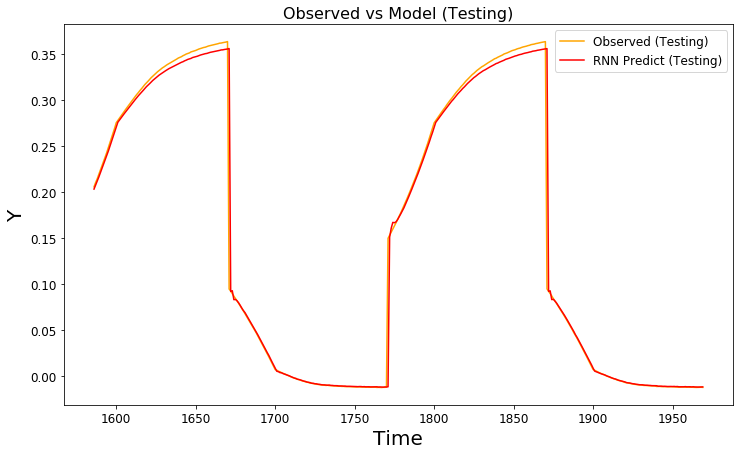

In [101]:
fig = plt.figure(figsize=(12,7))
test_line_real = plt.plot(df_test.index[n_steps:], df_test[use_feature][n_steps:], color="orange", label="Observed (Testing)")
test_line_pred = plt.plot(df_test.index[n_steps:], alpha_rnn_pred_test[:, 0], color="red", label="RNN Predict (Testing)")
plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model (Testing)', fontsize=16)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Y', fontsize=20)

plt.show()

In [0]:
def RNN_model(n_units=10, l1_reg=0):
    reg_model = Sequential()
    reg_model.add(SimpleRNN(n_units, activation='tanh', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
    reg_model.add(Dense(1, kernel_initializer='normal', kernel_regularizer=l1(l1_reg)))
    #reg_model.add(Dropout(0.2))
    reg_model.compile(loss='mean_squared_error', optimizer='adam')
    return reg_model

In [0]:
rnn_model=RNN_model(hidden_units, l1_reg)
rnn_model.fit(x_train_reg,y_train_reg,epochs=2000, batch_size=100, callbacks=[es])

In [70]:
rnn_pred_train = rnn_model.predict(x_train_reg, verbose=1)
rnn_pred_test = rnn_model.predict(x_test_reg, verbose=1)

384/384 [==============================] - 0s 38us/step


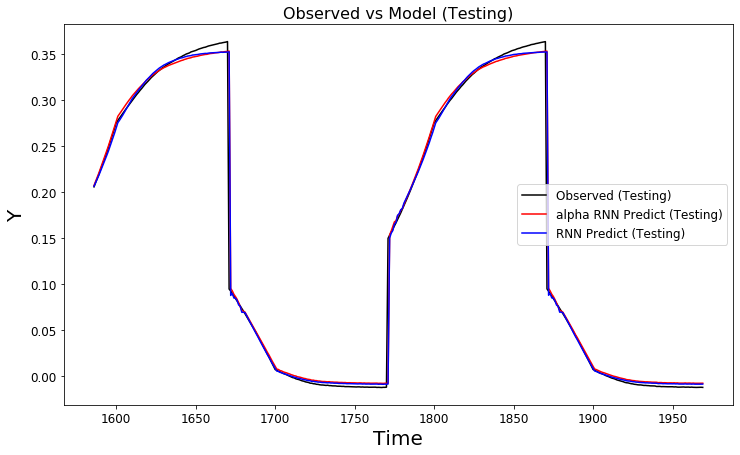

In [71]:
fig = plt.figure(figsize=(12,7))
test_line_real = plt.plot(df_test.index[n_steps:], df_test[use_feature][n_steps:], color="black", label="Observed (Testing)")
test_line_pred = plt.plot(df_test.index[n_steps:], alpha_rnn_pred_test[:, 0], color="red", label="alpha RNN Predict (Testing)")
plt.plot(df_test.index[n_steps:], rnn_pred_test[:, 0], color="blue", label="RNN Predict (Testing)")

plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model (Testing)', fontsize=16)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Y', fontsize=20)

plt.show()